In [35]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd


df =pd.read_csv('train.csv')

### UNCOMMENT THIS PART TO USE THE FEATURE ENGINEERING
df['total_call'] = df['total_day_calls'] + df['total_eve_calls'] + df['total_night_calls']

# Create 'total_charges' feature
df['total_charges'] = df['total_day_charge'] + df['total_eve_charge'] + df['total_night_charge']

# Create 'total_minutes' feature
df['total_minutes'] = df['total_day_minutes'] + df['total_eve_minutes'] + df['total_night_minutes']
df = df.drop(['total_day_calls', 'total_eve_calls', 'total_night_calls'], axis=1)

# Delete contributing features for 'total_charges'
df = df.drop(['total_day_charge', 'total_eve_charge', 'total_night_charge'], axis=1)

# Delete contributing features for 'total_minutes'
df = df.drop(['total_day_minutes', 'total_eve_minutes', 'total_night_minutes'], axis=1)






df.drop(['state', 'area_code', 'account_length'], axis=1, inplace=True)


###################

###ONE HOT ENCODING
# df = pd.get_dummies(df, columns=['area_code','state'])


### MOVING THE Y VARIABLE TO THE END
churn = df['churn']
df = df.drop('churn', axis=1)
df['churn'] = churn


data=np.array(df)


data[data=='no']=0
data[data=='yes']=1
data[data==False]=0
data[data==True]=1
X=data[:,:-1]
y=data[:,-1]



### SPLITTING THE DATA INTO TRAIN, VALIDATION AND TEST SETS

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42) 

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) 

###DATA NORMALIZATION
def normalize(X):
    X = X.astype(float)
    X=(X-X.mean(axis=0))/X.std(axis=0)
    return X
X_train = normalize(X_train)
X_val = normalize(X_val)
X_test = normalize(X_test)

#SMOTE, oversampling the minority class (will read more about this later)
X_train_oversampled_smote = []
labels_train_oversampled_smote = []
indices_0 = np.where(y_train == 0)[0]
indices_1 = np.where(y_train == 1)[0]
indices = np.concatenate([indices_0, indices_1])
for _ in range(X_train.shape[0]):
    p = np.random.random()
    #sample from majority class
    if p < 0.5:
        X_train_oversampled_smote.append(X_train[np.random.choice(indices_0)])
        labels_train_oversampled_smote.append(0)
    #sample from minority class
    else:
        #get two random samples from minority class
        minority_samp_1 = X_train[np.random.choice(indices_1)]
        minority_samp_2 = X_train[np.random.choice(indices_1)]
        
        #get random proportion with which to mix them
        prop = np.random.random()
        
        #generate synthetic sample from minority class
        synthetic_minority_samp = prop*minority_samp_1 + (1-prop)*minority_samp_2
        X_train_oversampled_smote.append(synthetic_minority_samp)
        labels_train_oversampled_smote.append(1)
        
X_train = np.array(X_train_oversampled_smote)
y_train = np.array(labels_train_oversampled_smote)

print(y_train[y_train==0].shape)
print(X_train.shape)

####################


(1481,)
(2975, 10)


In [36]:
### LOGISTIC REGRESSION IMPLEMENTATION

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def forward(X,W,b):
    A=np.dot(X,W)+b
    A=A.astype(float)
    return sigmoid(A)


### CROSS ENTROPY LOSS FUNCTION, USE TO EVALUATE THE MODEL
def loss(y,y_hat):
    return -np.mean(y*np.log(y_hat)+(1-y)*np.log(1-y_hat))


### GRADIENT DESCENT IMPLEMENTATION, USE TO TRAIN THE MODEL

def gradient_descent(X,y,W,b,learning_rate,epochs,regularization_term):
    costs=[]
    for epoch in range(epochs):
        
        y_hat = forward(X,W,b)
        l=loss(y,y_hat)
        print(f"Epoch: {epoch}, Loss: {l}")
        costs.append(l)
    
        Z=y_hat-y
        dW = (np.dot(X.T, Z) + regularization_term * W)/X.shape[0]
        db=np.mean(Z)
        dW=dW.astype(float)
        W=W-learning_rate*dW
        b=b-learning_rate*db
        
    return W,b,costs



def fit_logistic(X, y, lr, epochs, reg):
    W,b=np.random.randn(X.shape[1]),np.random.randn(1)
    W_fit,b_fit,costs  = gradient_descent(X, y, W, b, lr, epochs, reg)
    return W_fit, b_fit, costs


### PREDICTION AND ACCURACY FUNCTIONS

def predict(X,W,b,threshold=0.5):
    y_hat=forward(X,W,b)
    y_hat[y_hat>=threshold]=1
    y_hat[y_hat<threshold]=0
    return y_hat

def accuracy(y,y_hat):
    return np.sum(y==y_hat)/y.shape[0]
    

In [37]:
### HYPERPARAMETER TUNING

lr_value=[0.01,0.05,0.1,0.5]
reg_value=[0.01,0.05,0.1,0.5]
epoch_value=[5000,10000,20000]
max_accuracy=0

epoch = 10000

y_val=y_val.astype(float)
y_test=y_test.astype(float)
y_train=y_train.astype(float)
threshold_value=[0.5,0.6,0.7,0.8,0.9]
with open('output.txt', 'w') as f:
    pass

for lr in lr_value:
   for reg in reg_value:
      for threshold in threshold_value:
###FITTING THE MODEL
         
         W, b, costs = fit_logistic(X_train, y_train, lr, epoch, reg)
### USING W and b to predict the validation set
         y_hat = predict(X_val, W, b, threshold=threshold)
         acc_val=accuracy(y_val,y_hat)
### CALCULATING THE ACCURACY, if the accuracy improved, we save the variables
         if acc_val>max_accuracy:
            W_best_fit=W
            b_best_fit=b
            costs_best_fit=costs
            max_accuracy=acc_val
            
            
### WRITING THE RESULTS IN A FILE to keep track of the training process
         with open('output.txt', 'a') as f:
            f.write(f"Training with epoch={epoch}, lr={lr}, reg={reg}\n")
            f.write("-------------------------------------------------\n")
            f.write('\n')
            f.write(f"Validation Loss: {loss(y_val,forward(X_val,W,b))}\n")
            f.write(f"Validation Accuracy: {accuracy(y_val,y_hat)}\n")
            y_test_hat=predict(X_test,W,b,threshold=threshold)
            f.write("Test loss:{}\n".format(loss(y_test,forward(X_test,W,b))))
            f.write("Test accuracy:{}\n".format(accuracy(y_test,y_test_hat)))
            f.write("-------------------------------------------------\n")
            f.write("\n")
            f.close()


### REPEATING THE SAME PROCESS FOR REGULARIZATION AND EPOCHS


### SAVING THE BEST FIT VARIABLES
np.savez('weights.npz', W=W_best_fit, b=b_best_fit,costs=costs_best_fit,lr=default_lr,reg=default_reg,epoch=default_epoch)




    
 


Epoch: 0, Loss: 1.6824076307221445
Epoch: 1, Loss: 1.6801397479656726
Epoch: 2, Loss: 1.677874032151875
Epoch: 3, Loss: 1.6756104844577375
Epoch: 4, Loss: 1.6733491060576624
Epoch: 5, Loss: 1.671089898123072
Epoch: 6, Loss: 1.6688328618227601
Epoch: 7, Loss: 1.66657799832269
Epoch: 8, Loss: 1.6643253087860221
Epoch: 9, Loss: 1.6620747943730219
Epoch: 10, Loss: 1.659826456241163
Epoch: 11, Loss: 1.657580295545205
Epoch: 12, Loss: 1.6553363134368992
Epoch: 13, Loss: 1.6530945110651563
Epoch: 14, Loss: 1.6508548895760786
Epoch: 15, Loss: 1.6486174501129205
Epoch: 16, Loss: 1.6463821938158756
Epoch: 17, Loss: 1.644149121822497
Epoch: 18, Loss: 1.6419182352672428
Epoch: 19, Loss: 1.6396895352816347
Epoch: 20, Loss: 1.6374630229944311
Epoch: 21, Loss: 1.6352386995313162
Epoch: 22, Loss: 1.6330165660150902
Epoch: 23, Loss: 1.6307966235655684
Epoch: 24, Loss: 1.6285788732996138
Epoch: 25, Loss: 1.6263633163311408
Epoch: 26, Loss: 1.6241499537710546
Epoch: 27, Loss: 1.6219387867272395
Epoch: 28

KeyboardInterrupt: 

Threshold: 0.1, F1 Score: 0.3306055646481178
Threshold: 0.2, F1 Score: 0.39679358717434865
Threshold: 0.30000000000000004, F1 Score: 0.48157248157248156
Threshold: 0.4, F1 Score: 0.5125348189415042
Threshold: 0.5, F1 Score: 0.5324675324675324
Threshold: 0.6, F1 Score: 0.5597014925373134
Threshold: 0.7000000000000001, F1 Score: 0.5622119815668203
Threshold: 0.8, F1 Score: 0.5027322404371586
Threshold: 0.9, F1 Score: 0.37333333333333335


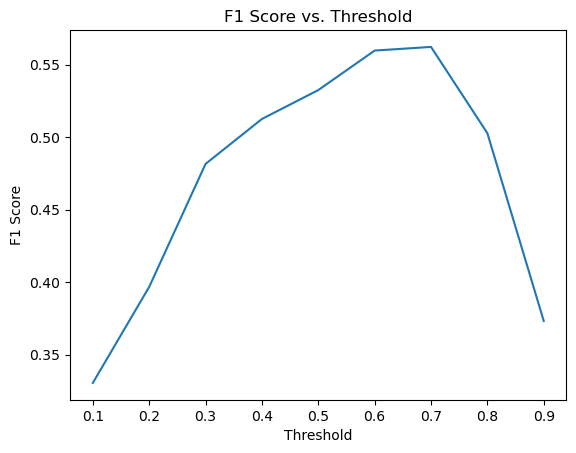

In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score
import numpy as np
# Define thresholds
thresholds = np.arange(0.1, 1.0, 0.1)


weights=np.load('weights.npz')
W=weights['W']
b=weights['b']

# Predict on test set
y_pred = predict(X_test, W, b, threshold=default_threshold)

y_pred=y_pred.astype(int)
y_test=y_test.astype(int)
# Initialize list to store F1 scores
f1_scores = []
best_threshold=0
best_f1=0
# Loop over thresholds
for threshold in thresholds:
    # Predict on test set
    y_pred = predict(X_test, W, b, threshold=threshold)
    
    # Calculate F1 score
    f1 = f1_score(y_test, y_pred)
    if f1>best_f1:
        best_threshold=threshold
        best_f1=f1
    # Append F1 score to list
    f1_scores.append(f1)

# Print F1 scores
for threshold, f1 in zip(thresholds, f1_scores):
    print(f'Threshold: {threshold}, F1 Score: {f1}')
    
# Plot F1 scores
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.show()


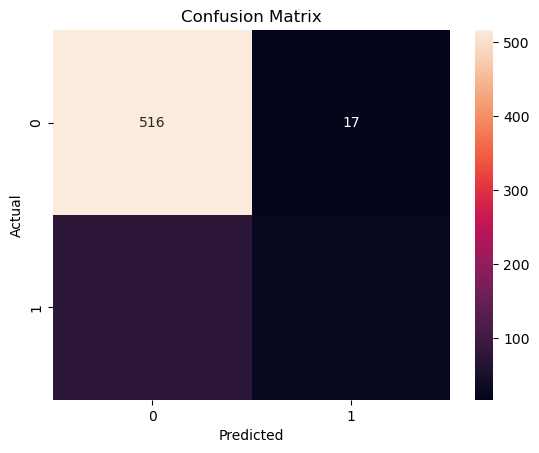

Test accuracy: 0.8526645768025078
0.7000000000000001
[[516  17]
 [ 77  28]]


In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print(f"Test accuracy: {accuracy(y_test, y_pred)}")
print(best_threshold)
print(cm)


In [ ]:
from sklearn.metrics import accuracy_score

y_pred = predict(X_val, W, b, threshold=best_threshold)

print(accuracy(y_val, y_pred))

0.8084772370486656
